## Import libraries

In [1]:
import os
import glob
import pickle
from pathlib import Path, PureWindowsPath

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns 

## Config

In [2]:
class cfg:

    THIS_NOTEBOOK_ID: "FR_t01e01nb04v1"

    #=================================================
    ROOT_TRAINING_RSLTS = os.path.join('..', '..', '..',
                                       "results",
                                       "exp_track",
                                      )

## Utility functions

### flatten_dict()

In [3]:
def flatten_dict(d, parent_key='', sep='_'):
    """
    Description
    -----------
        Recursive, inspect inner dict and extract values

    Return: 
    ------
        flat_dictionary: It can be use as one row of a dataframe.
    """
    
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k

        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))

    return dict(items)

### perf_last_epoch_metric_distr_info()

In [4]:
def perf_last_epoch_metric_distr_info(d_meta, 
                                      arch_name_wild_card="resnet", 
                                      pipe_names=['pipe001']): 
    
    """
    Description:
    -----------
        Selecting and extracting performances on test for each fold, and then calculating
            distribution information "'mean', 'std', 'min', '25%', '50%', '75%', 'max'" 
            
    Parameters:
    -----------
        arch_name_wild_card: to select the architecture of interest
        pipe_names: list of preprocessing image pipeline id of interest

    Return: 
        d_m: dataframe organize to show for each training track id, the test performances across folds.

    """
    
    c1 = d_meta['architecture__arch_ID'].str.lower().str.contains(arch_name_wild_card)
    c2 = d_meta['prepro_pipe__pipe_name'].isin(pipe_names)
    
    d = d_meta[c1&c2].reset_index(drop=True)
    d
    
    
    #==========================================
    # Extracting performances, fold, leakage or not leakage
    track_slct_info = []
    for r, data in d.iterrows():
    
        #- - - - - - - - - - - - - - - - - 
        # Extracting information related to performance per epoch during training process. 
        fpath = data['path_perf_dct']
        with open(fpath, 'rb') as f:
            perf_dct = pickle.load(f)
            """
            perf_dct keys: 
                ['prcsn_trn', 'f1score_trn', 'rec_trn', 'ba_trn', 'acc_trn', 'loss_trn', 
                 'prcsn_tst', 'f1score_tst', 'rec_tst', 'ba_tst', 'acc_tst', 'loss_tst', 
                 'lr', 'track_train_id', 'fold_id', 'arch_id']
    
            """
            
        
    
        #- - - - - - - - - - - - - - - - - 
        track_slct_info.append([
            data['track_train_id'], 
            data['split_strategy__split_strategy_id'],
            data['training_step__training_strategy_id'],
            data['architecture__arch_ID'],
            data['fold_id'], 
            data['path_perf_dct'], 
            data['prepro_pipe__pipe_name'],
            data['split_strategy__shuffle_instances'], #True:leakage, False: 'no_leakage'
            data["training_step__epochs"],
            perf_dct['acc_tst'][-1], # last epoch performance
            perf_dct['ba_tst'][-1], # last epoch performance
            perf_dct['f1score_tst'][-1], # last epoch performance
            perf_dct['prcsn_tst'][-1], # last epoch performance
            perf_dct['rec_tst'][-1], # last epoch performance
        ])
    
        #_____________________________________
        # break
    #_________________________________________
    
    
    #===========================================================
    # Extracting test performance of last epoch of each fold. 
    cols = ['track_train_id', 'split_id', 'trn_strtgy_id', 'arch_name', 'fold_id', 'path_perf_dct', 'prepro_pipe__pipe_name', 
            'leakage', 'training_step__epochs', 'acc_tst', 'ba_tst', 'f1score_tst', 'prcsn_tst', 'rec_tst']
    d_m = pd.DataFrame(track_slct_info, columns=cols)
    d_m
    
    #===========================================================
    # Extracting summary (across fold) for same Track_ID
    metrics_dist_info = []
    for gr, data in d_m.groupby(['track_train_id', 'prepro_pipe__pipe_name', 'arch_name', 'split_id', 'trn_strtgy_id','leakage', 'training_step__epochs']): 
        #___________________________________________________
        # Calculating test metrics performance distribution info (last training epoch)
        cols = ['acc_tst', 'ba_tst', 'f1score_tst', 'prcsn_tst', 'rec_tst']
        d = data[cols].describe().T.reset_index().rename(columns={'index':'metrics'})
        
        #___________________________________________________
        # Adding meta info
        d[['track_train_id', 'pre_pipe_id', 'arch_name', 'split_id', 'trn_strtgy_id','leakage', 'n_epochs']] = gr
        
        #___________________________________________________
        # Reorganization of table
        cols = ['track_train_id', 'pre_pipe_id', 'arch_name', 'split_id', 'trn_strtgy_id','leakage', 'n_epochs', 
                'metrics', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max',]
        d = d[cols]
        d = d.rename(columns={'count':'fold_cnt'})
        
        #___________________________________________________
        # Store
        metrics_dist_info.append(d)
    
        #___________________________________________________
        # break
    #_______________________________________________________
    d_m = pd.concat(metrics_dist_info,  ignore_index=True)
    d_m = d_m.sort_values(by=['pre_pipe_id', 'arch_name', 'trn_strtgy_id',"track_train_id",'split_id', "leakage",], ignore_index=True)

    return d_m

## Extract performance during training epochs

In [5]:
#=====================================================================
# READ DATA
ROOT_DATA = cfg.ROOT_TRAINING_RSLTS

model_epo_perf = glob.glob(os.path.join(ROOT_DATA, '*', 'perform_acrss_epo', "*", "performance_across_Epochs.pkl"))
model_epo_perf

#=====================================================================
# LOOP across each perforamnce directory
perf_meta = []
for p in model_epo_perf: 

    #_____________
    # Read file
    with open(p, 'rb') as f:
        perf_dct = pickle.load(f)

    #_____________
    # Extract keys
    trnTrackID = perf_dct['track_train_id']
    foldID = perf_dct['fold_id'] # nomenclature: f"seed{random_state in Kfold fun}_fold(n of data splits)
    archID = perf_dct['arch_id']

    perf_meta.append([trnTrackID, 
                      foldID, 
                      archID, 
                      p, 
                     ])

    #_________________________________________________
    # break
#=====================================================================
# Create metadatabase for perforamnces during training epochs during training.
cols = ['track_train_id', 'fold_id', 'arch_id', 'path_perf_dct']
d_prf_meta = pd.DataFrame(perf_meta, columns=cols)
d_prf_meta.head()

,track_train_id,fold_id,arch_id,path_perf_dct
0,TrainTrack_005,seed0_fold4,RESNET_v1,../../../results/exp_track/TrainTrack_005/perf...
1,TrainTrack_005,seed0_fold3,RESNET_v1,../../../results/exp_track/TrainTrack_005/perf...
2,TrainTrack_005,seed0_fold1,RESNET_v1,../../../results/exp_track/TrainTrack_005/perf...
3,TrainTrack_005,seed0_fold0,RESNET_v1,../../../results/exp_track/TrainTrack_005/perf...
4,TrainTrack_005,seed0_fold2,RESNET_v1,../../../results/exp_track/TrainTrack_005/perf...


In [6]:
pickle_fpath = d_prf_meta["path_perf_dct"][0]
with open(pickle_fpath, 'rb') as f:
    perf_dct = pickle.load(f)

perf_dct.keys()

dict_keys(['prcsn_trn', 'f1score_trn', 'rec_trn', 'ba_trn', 'acc_trn', 'loss_trn', 'prcsn_tst', 'f1score_tst', 'rec_tst', 'ba_tst', 'acc_tst', 'loss_tst', 'lr', 'track_train_id', 'fold_id', 'arch_id'])

**performance_across_Epochs.pkl:**
- For each epoch it calculates and stores performance metrics for training and test sets

## Extract Params for the whole ML pipeline

In [7]:
ROOT_DATA = cfg.ROOT_TRAINING_RSLTS

ml_pipe_params_paths = glob.glob(os.path.join(ROOT_DATA, '*', 'ML_pipe_params', "ML_pipe_all_params_*.pkl"))
ml_pipe_params_paths

#=========================================================================
# LOOP across each perforamnce directory
ml_parms_meta = []
for p in ml_pipe_params_paths:

    #________________________
    # Read file 
    with open(p, 'rb') as f:
        ml_pipe_parms_dct = pickle.load(f)
    #________________________
    # Flat dictionary
    flat_dct = flatten_dict(ml_pipe_parms_dct, parent_key='', sep='__')

    
    #________________________
    # Store
    ml_parms_meta.append(flat_dct)

    #________________________
    # break
#----------------------------
# if a dictionary key is missing in some Training Track IDs, due to diff architecture, training, etc
#  -- it needs to be added with Nan values. <<--- Pending
d_ml_pipe_params = pd.DataFrame(ml_parms_meta)
d_ml_pipe_params.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   prepro_pipe__pipe_name                10 non-null     object 
 1   prepro_pipe__source_code              10 non-null     object 
 2   architecture__arch_ID                 10 non-null     object 
 3   architecture__params__block           4 non-null      object 
 4   architecture__params__layers          4 non-null      object 
 5   architecture__params__image_channels  8 non-null      float64
 6   architecture__params__num_classes     10 non-null     int64  
 7   architecture__source_code             10 non-null     object 
 8   split_strategy__split_strategy_id     10 non-null     object 
 9   split_strategy__cv                    10 non-null     object 
 10  split_strategy__n_split               10 non-null     int64  
 11  split_strategy__cls_co

## Extract prediction (y_pred per instance) of final training epoch

In [8]:
split_rslts = "test_result.csv" # last training epoch of that training track

ROOT_DATA = cfg.ROOT_TRAINING_RSLTS

ypred_rslts_paths = glob.glob(os.path.join(ROOT_DATA, "*", "predictions", "*", split_rslts,))
ypred_rslts_paths

['../../../results/exp_track/TrainTrack_005/predictions/seed0_fold4/test_result.csv',
 '../../../results/exp_track/TrainTrack_005/predictions/seed0_fold3/test_result.csv',
 '../../../results/exp_track/TrainTrack_005/predictions/seed0_fold1/test_result.csv',
 '../../../results/exp_track/TrainTrack_005/predictions/seed0_fold0/test_result.csv',
 '../../../results/exp_track/TrainTrack_005/predictions/seed0_fold2/test_result.csv',
 '../../../results/exp_track/TrainTrack_006/predictions/seed0_fold4/test_result.csv',
 '../../../results/exp_track/TrainTrack_006/predictions/seed0_fold3/test_result.csv',
 '../../../results/exp_track/TrainTrack_006/predictions/seed0_fold1/test_result.csv',
 '../../../results/exp_track/TrainTrack_006/predictions/seed0_fold0/test_result.csv',
 '../../../results/exp_track/TrainTrack_006/predictions/seed0_fold2/test_result.csv',
 '../../../results/exp_track/TrainTrack_010/predictions/seed0_fold4/test_result.csv',
 '../../../results/exp_track/TrainTrack_010/prediction

In [9]:
tst_rslts = pd.read_csv(ypred_rslts_paths[0])
tst_rslts["y_true"].value_counts()

y_true
2    112
0     83
1     24
Name: count, dtype: int64

In [10]:
tst_rslts["y_true"].shape

(219,)

In [11]:
class_counts = tst_rslts["y_true"].value_counts(normalize=True)  # gives class proportions
class_counts

y_true
2    0.511416
0    0.378995
1    0.109589
Name: proportion, dtype: float64

In [12]:
class_counts = tst_rslts["y_true"].value_counts(normalize=True)  # gives class proportions
expected_random_accuracy = (class_counts ** 2).sum()
expected_random_accuracy

0.41719313608973957

## TRACK META - GLobal

**This DataFrame will contain all information related to:**
- Complete DL Pipelines
- path to pickle file that contains the metric performance calculated during training epochs

In [13]:
d_meta = d_prf_meta.merge(d_ml_pipe_params,
                          how="left",
                          left_on="track_train_id",
                          right_on="training_step__TrackID")
d_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 34 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   track_train_id                        50 non-null     object 
 1   fold_id                               50 non-null     object 
 2   arch_id                               50 non-null     object 
 3   path_perf_dct                         50 non-null     object 
 4   prepro_pipe__pipe_name                50 non-null     object 
 5   prepro_pipe__source_code              50 non-null     object 
 6   architecture__arch_ID                 50 non-null     object 
 7   architecture__params__block           20 non-null     object 
 8   architecture__params__layers          20 non-null     object 
 9   architecture__params__image_channels  40 non-null     float64
 10  architecture__params__num_classes     50 non-null     int64  
 11  architecture__source_

## VIZ Performances comparison

In [14]:
metric = 'acc_tst'
#==================================
metric_perf = []
for r, data in d_meta.iterrows():
    
    #---------------------------------------
    # Load performance during training epochs.
    performance_during_training_path = Path(PureWindowsPath(data["path_perf_dct"]))
    with open(performance_during_training_path, 'rb') as f:
        perf_dct = pickle.load(f)
        """
        Keys: 
            ['prcsn_trn', 'f1score_trn', 'rec_trn', 'ba_trn', 'acc_trn', 'loss_trn', 
             'prcsn_tst', 'f1score_tst', 'rec_tst', 'ba_tst', 'acc_tst', 'loss_tst', 
             'lr', 'track_train_id', 'fold_id', 'arch_id']

        """

    #---------------------------------------
    # Extracting metric performance selected during training epochs. 
    metric_perf.append((data["track_train_id"], 
                        perf_dct[metric],
                        data["split_strategy__shuffle_instances"]
                       ),
                       )

    #________________________________________________
    # break
#---------------------------------------------------
cols = ["track_train_id", "metric_vals", "leak"]
d_metric_perf = pd.DataFrame(metric_perf, columns=cols)
d_metric_perf

,track_train_id,metric_vals,leak
0,TrainTrack_005,"[0.589041095890411, 0.680365296803653, 0.81278...",True
1,TrainTrack_005,"[0.5342465753424658, 0.8082191780821918, 0.726...",True
2,TrainTrack_005,"[0.4885844748858447, 0.6575342465753424, 0.757...",True
3,TrainTrack_005,"[0.7330316742081447, 0.746606334841629, 0.7013...",True
4,TrainTrack_005,"[0.6940639269406392, 0.6529680365296804, 0.589...",True
5,TrainTrack_006,"[0.8036529680365296, 0.6027397260273972, 0.598...",False
6,TrainTrack_006,"[0.5114155251141552, 0.7442922374429224, 0.630...",False
7,TrainTrack_006,"[0.6666666666666666, 0.4977168949771689, 0.515...",False
8,TrainTrack_006,"[0.49321266968325794, 0.6515837104072398, 0.66...",False
9,TrainTrack_006,"[0.639269406392694, 0.7123287671232876, 0.7351...",False


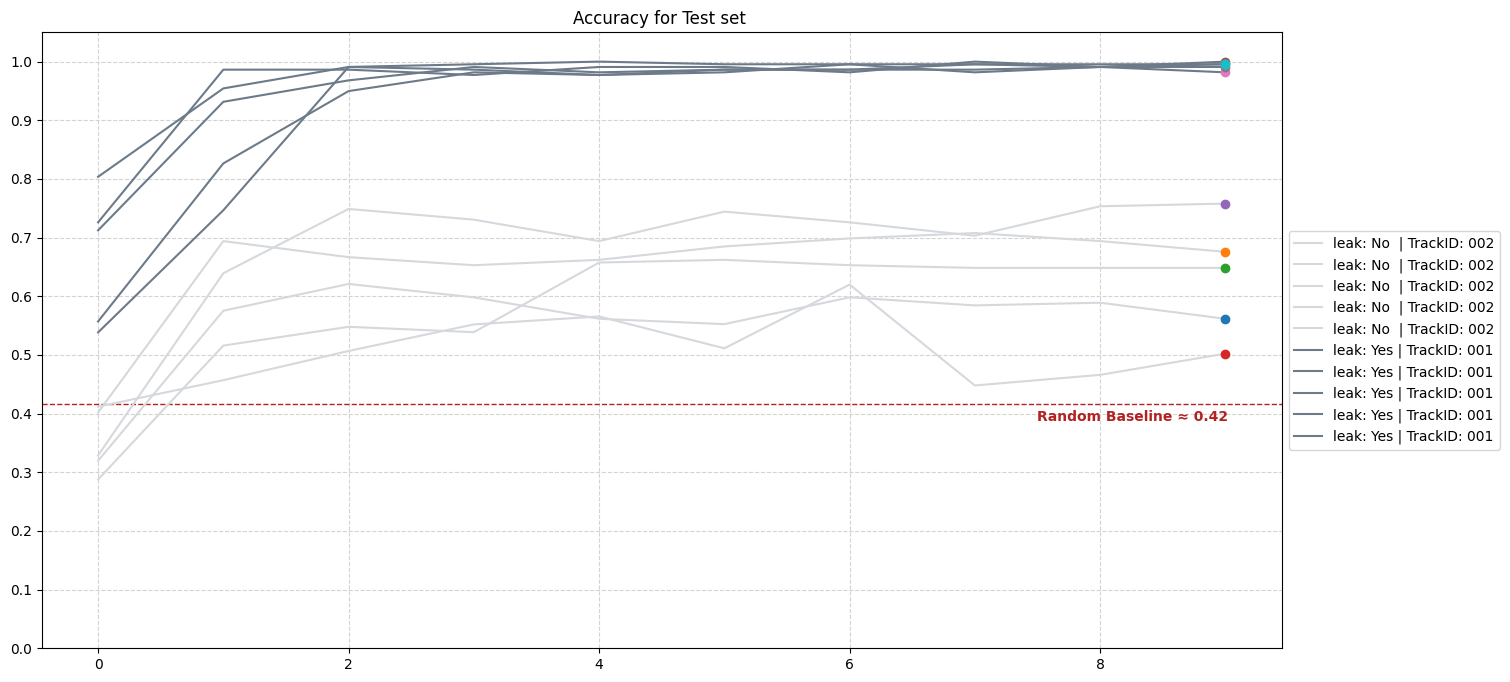

In [15]:
c1 = d_metric_perf['track_train_id'].isin(['TrainTrack_001', 'TrainTrack_002'])

from matplotlib.lines import Line2D
custom_legend_handles1, custom_legend_handles2 = [], []
plt.figure(figsize=(16,8))
for r, data in d_metric_perf[c1].sort_values(by=["leak"]).iterrows():

    #_______________________________________________________
    # Creating series label 
    leakage_exp = data["leak"]
    track = data["track_train_id"]
    
    leak = "Yes" if leakage_exp else "No "
    track = track.split("_")[1]
    serie_label_name = f"leak: {leak} | TrackID: {track}"

    #_______________________________________________________
    serie_values = data["metric_vals"]

    #_______________________________________________________
    color_line = "#6C7A89" if leakage_exp else "#D5D8DC"
    plt.plot(serie_values, label=serie_label_name, color=color_line, zorder=3)

    # last epoch performace
    sc = plt.scatter(len(serie_values) - 1, serie_values[-1], zorder=3)
    #----------------------------

    legend_label = (
        f'{serie_label_name}: '
        f'$\u2015$'  # Unicode for horizontal line
        f' (line)  '
        f'$\u25CF$'  # Unicode for filled circle with this color : sc.get_facecolor()[0]
        f' (marker)' 
    )
    custom_legend_handles1.append(Line2D(
        [0], [0],
        color=color_line,
        # marker='o',
        # markerfacecolor=sc.get_facecolor()[0],
        # label=f'{serie_label_name}: line + marker'
        label=legend_label,
    ))
    # custom_legend_handles2.append(Line2D(
    #     [0], [0],
    #     # color=color_line,
    #     marker='o',
    #     # markerfacecolor=sc.get_facecolor()[0],
    #     # label=f'{serie_label_name}: line + marker'
    #     label=legend_label,
    # ))




    #_______________________________________________________
    # break
#-----------------------------------------------------------
plt.axhline(expected_random_accuracy, color='firebrick', linestyle='--', linewidth=1, 
            # label='Random Baseline', 
           )
# Annotate the line
plt.text(
    x=7.5, 
    y=expected_random_accuracy - 0.03, 
    s=f'Random Baseline ≈ {expected_random_accuracy:.2f}',
    color='firebrick',
    fontsize=10,
    fontweight='bold'
)

plt.title("Accuracy for Test set ")
# plt.legend(handles=[(custom_legend_handles1, custom_legend_handles2)])
# plt.legend(handles=custom_legend_handles1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(color='lightgray', linestyle="--", zorder=0 )
plt.yticks(np.arange(0, 1.1, 0.1)) 
plt.ylim(0,1.05)
plt.show()

# Tracking DL pipeline hyperameters

## Split strategy | without track seed.

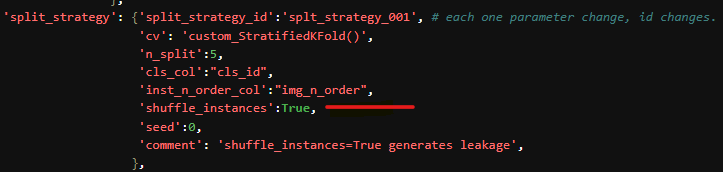

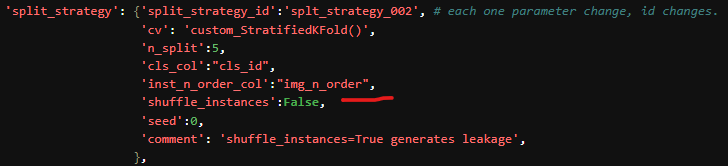

## Training Strategy params

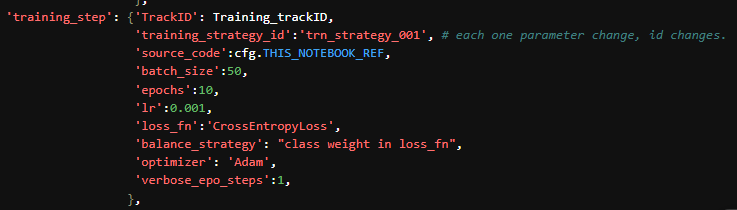

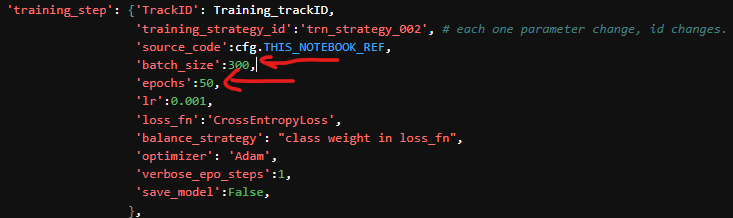

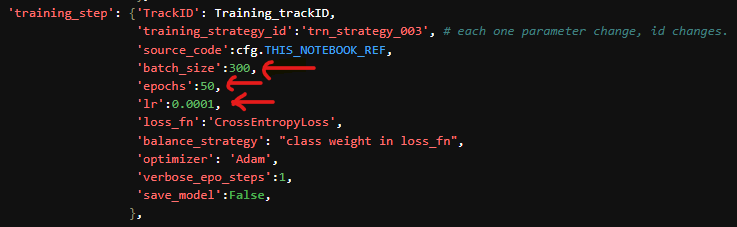

# Report

## Vanilla CNN | Pipe001

In [16]:
d_m = perf_last_epoch_metric_distr_info(d_meta, arch_name_wild_card="vanilla", 
                                        pipe_names=['pipe001'])
d_m

,track_train_id,pre_pipe_id,arch_name,split_id,trn_strtgy_id,leakage,n_epochs,metrics,fold_cnt,mean,std,min,25%,50%,75%,max
0,TrainTrack_001,pipe001,vanilla2DCNN_v1,splt_strategy_001,trn_strategy_001,True,10,acc_tst,5.0,0.992702,0.006929,0.981735,0.990868,0.995434,0.995475,1.000000
1,TrainTrack_001,pipe001,vanilla2DCNN_v1,splt_strategy_001,trn_strategy_001,True,10,ba_tst,5.0,0.978514,0.021028,0.946285,0.973143,0.979167,0.993976,1.000000
2,TrainTrack_001,pipe001,vanilla2DCNN_v1,splt_strategy_001,trn_strategy_001,True,10,f1score_tst,5.0,0.987748,0.012374,0.969210,0.982095,0.990935,0.996498,1.000000
3,TrainTrack_001,pipe001,vanilla2DCNN_v1,splt_strategy_001,trn_strategy_001,True,10,prcsn_tst,5.0,0.989950,0.011052,0.974525,0.982095,0.996078,0.997050,1.000000
4,TrainTrack_001,pipe001,vanilla2DCNN_v1,splt_strategy_001,trn_strategy_001,True,10,rec_tst,5.0,0.985676,0.014019,0.964190,0.982095,0.986111,0.995984,1.000000
5,TrainTrack_002,pipe001,vanilla2DCNN_v1,splt_strategy_002,trn_strategy_001,False,10,acc_tst,5.0,0.629220,0.099755,0.502262,0.561644,0.648402,0.675799,0.757991
6,TrainTrack_002,pipe001,vanilla2DCNN_v1,splt_strategy_002,trn_strategy_001,False,10,ba_tst,5.0,0.340235,0.175468,0.182426,0.203382,0.255576,0.515508,0.544284
7,TrainTrack_002,pipe001,vanilla2DCNN_v1,splt_strategy_002,trn_strategy_001,False,10,f1score_tst,5.0,0.565264,0.104724,0.480887,0.487167,0.499236,0.669946,0.689086
8,TrainTrack_002,pipe001,vanilla2DCNN_v1,splt_strategy_002,trn_strategy_001,False,10,prcsn_tst,5.0,0.659786,0.067995,0.572511,0.601160,0.694097,0.711334,0.719826
9,TrainTrack_002,pipe001,vanilla2DCNN_v1,splt_strategy_002,trn_strategy_001,False,10,rec_tst,5.0,0.560157,0.116979,0.454951,0.468921,0.503717,0.677006,0.696190


## RESNET | PIPE001

In [17]:
d_m = perf_last_epoch_metric_distr_info(d_meta, arch_name_wild_card="resnet", 
                                        pipe_names=['pipe001'])
d_m

,track_train_id,pre_pipe_id,arch_name,split_id,trn_strtgy_id,leakage,n_epochs,metrics,fold_cnt,mean,std,min,25%,50%,75%,max
0,TrainTrack_003,pipe001,RESNET_v1,splt_strategy_001,trn_strategy_001,True,10,acc_tst,5.0,0.446637,0.054383,0.351598,0.456621,0.466063,0.470320,0.488584
1,TrainTrack_003,pipe001,RESNET_v1,splt_strategy_001,trn_strategy_001,True,10,ba_tst,5.0,0.072049,0.102797,-0.062697,0.024401,0.058771,0.134376,0.205393
2,TrainTrack_003,pipe001,RESNET_v1,splt_strategy_001,trn_strategy_001,True,10,f1score_tst,5.0,0.373715,0.060990,0.286788,0.348071,0.375259,0.413433,0.445026
3,TrainTrack_003,pipe001,RESNET_v1,splt_strategy_001,trn_strategy_001,True,10,prcsn_tst,5.0,0.379207,0.049016,0.313420,0.350830,0.382876,0.410870,0.438038
4,TrainTrack_003,pipe001,RESNET_v1,splt_strategy_001,trn_strategy_001,True,10,rec_tst,5.0,0.381366,0.068531,0.291535,0.349601,0.372514,0.422918,0.470262
5,TrainTrack_004,pipe001,RESNET_v1,splt_strategy_002,trn_strategy_001,False,10,acc_tst,5.0,0.367351,0.017394,0.347032,0.351598,0.374429,0.375566,0.388128
6,TrainTrack_004,pipe001,RESNET_v1,splt_strategy_002,trn_strategy_001,False,10,ba_tst,5.0,-0.017129,0.048776,-0.079640,-0.045683,-0.020149,0.016530,0.043298
7,TrainTrack_004,pipe001,RESNET_v1,splt_strategy_002,trn_strategy_001,False,10,f1score_tst,5.0,0.302172,0.031685,0.265009,0.270486,0.319338,0.327559,0.328469
8,TrainTrack_004,pipe001,RESNET_v1,splt_strategy_002,trn_strategy_001,False,10,prcsn_tst,5.0,0.348270,0.063175,0.277884,0.314719,0.349710,0.351405,0.447630
9,TrainTrack_004,pipe001,RESNET_v1,splt_strategy_002,trn_strategy_001,False,10,rec_tst,5.0,0.321914,0.032517,0.280240,0.302878,0.319901,0.344354,0.362199


**TrainTrack 004 and 003**
- A clear example showing that a poorly configured algorithm can perform worse than simpler algorithms (e.g., vanilla 2D CNN), even when those simpler models suffer from data leakage.


**TrainTrack 005 and 006:**

Only Training step strategy was updated. 
- Pipe001 outputs images with raw pixel values. Even though ResNet includes batch normalization layers, small batch sizes are likely to cause instability.
- Larger batch sizes and more training epochs were used to improve stability, with the expectation of achieving over 90% accuracy with leakage, and close to 70% without leakage.

## ALEXNET | PIPE001

In [18]:
d_m = perf_last_epoch_metric_distr_info(d_meta, arch_name_wild_card="alexnet", 
                                        pipe_names=['pipe001'])
d_m

,track_train_id,pre_pipe_id,arch_name,split_id,trn_strtgy_id,leakage,n_epochs,metrics,fold_cnt,mean,std,min,25%,50%,75%,max
0,TrainTrack_007,pipe001,ALEXNET_v1,splt_strategy_001,trn_strategy_001,True,10,acc_tst,5.0,0.432873,0.181139,0.109589,0.502262,0.506849,0.511416,0.534247
1,TrainTrack_007,pipe001,ALEXNET_v1,splt_strategy_001,trn_strategy_001,True,10,ba_tst,5.0,0.057729,0.061482,0.000000,0.000000,0.044617,0.119030,0.125000
2,TrainTrack_007,pipe001,ALEXNET_v1,splt_strategy_001,trn_strategy_001,True,10,f1score_tst,5.0,0.270114,0.127761,0.065844,0.225579,0.335280,0.346542,0.377323
3,TrainTrack_007,pipe001,ALEXNET_v1,splt_strategy_001,trn_strategy_001,True,10,prcsn_tst,5.0,0.279592,0.175575,0.036530,0.170472,0.333088,0.379687,0.478185
4,TrainTrack_007,pipe001,ALEXNET_v1,splt_strategy_001,trn_strategy_001,True,10,rec_tst,5.0,0.371819,0.040988,0.333333,0.333333,0.363078,0.412686,0.416667
5,TrainTrack_008,pipe001,ALEXNET_v1,splt_strategy_002,trn_strategy_001,False,10,acc_tst,5.0,0.280076,0.135263,0.109589,0.158371,0.356164,0.378995,0.397260
6,TrainTrack_008,pipe001,ALEXNET_v1,splt_strategy_002,trn_strategy_001,False,10,ba_tst,5.0,0.052456,0.064223,0.000000,0.000000,0.035319,0.073150,0.153812
7,TrainTrack_008,pipe001,ALEXNET_v1,splt_strategy_002,trn_strategy_001,False,10,f1score_tst,5.0,0.215405,0.125336,0.065844,0.139687,0.183223,0.327476,0.360797
8,TrainTrack_008,pipe001,ALEXNET_v1,splt_strategy_002,trn_strategy_001,False,10,prcsn_tst,5.0,0.285231,0.189621,0.036530,0.126332,0.400416,0.412698,0.450177
9,TrainTrack_008,pipe001,ALEXNET_v1,splt_strategy_002,trn_strategy_001,False,10,rec_tst,5.0,0.368304,0.042815,0.333333,0.333333,0.356879,0.382100,0.435874


**AlexNet**
- user larger kernel size in the first 2D CNN layers compared to Vanilla2DCNN and RESNET18. Therefore, initially is very sensitive to inputs (img) scales and gradients.
- Has no mechanism to normalize internal activations, so it's vulnerable to high variance in gradients
    - AlexNet’s early layers can produce very large activations, especially with unnormalized inputs (pixel values 0–255)
- Small batches gradient estimtes are more noisy, each mini-batch gives a slightly different direction for optimization
- so, smaller lr control activation, larger batch less noisy gradients estimates creating, helping to reach estability faster, but to be sure, increase number of training epochs. 